In [25]:
import numpy as np

def PL_copilot(distance: float, freq: float, h_t: float, h_r: float) -> float:
    """
    distance: distance between transmitter and receiver (m)
    freq: frequency (Hz)
    h_t: height of transmitter (m)
    h_r: height of receiver (m)
    """
    return 20 * np.log10(distance) + 20 * np.log10(freq) + 32.44 - 10 * np.log10((h_t - h_r) ** 2 + distance ** 2)

def PL_sBS(distance: float, Xa: float = 10):
    """
    Path loss for carrier frequency 2000MHz and height of 15m
    """
    return 128.1 + 37.6 * np.log10(distance) + Xa

def PL_mBS(distance: float, Xa: float = 10):
    """
    Path loss for carrier frequency 900MHz and height of 45m
    """
    return 95.5 + 34.01 * np.log10(distance) + Xa

pl_dB = 100
amp = 10000
attenuated_amp = amp * 10 ** (-pl_dB / 20)                      

NameError: name 'pl' is not defined

(0.0, 500.0)

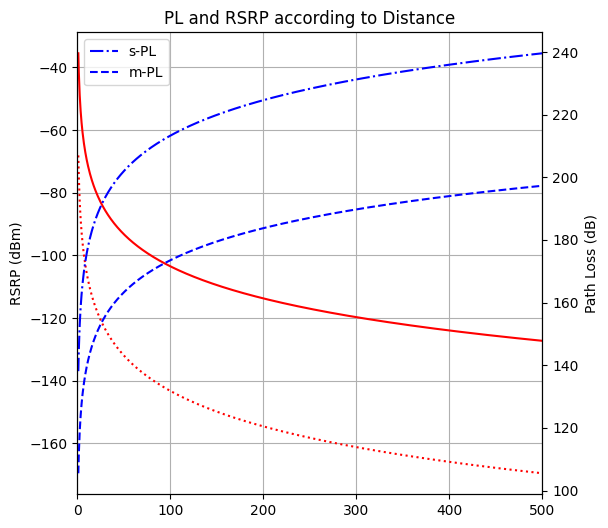

In [24]:
import matplotlib.pyplot as plt

# Propogation Loss per Distance

dist = np.linspace(1, 500, 1000)

# plt.figure(figsize=(6, 6))
fig, ax1 = plt.subplots()
fig.set_size_inches(6, 6)
# Add gridlines
plt.grid(True)
plt.title("PL and RSRP according to Distance")

ax2 = ax1.twinx()
plt.xlabel("Distance (m)")

ax1.set_ylabel("RSRP (dBm)")
TPTG = 70
ax1.plot(dist, -PL_sBS(dist) + TPTG, label='s-RSRP', linestyle='dotted', color='red')
ax1.plot(dist, -PL_mBS(dist) + TPTG, label='m-RSRP', linestyle='-', color='red')

ax2.set_ylabel("Path Loss (dB)")
ax2.plot(dist, PL_sBS(dist), label='s-PL', linestyle='-.', color='blue')
ax2.plot(dist, PL_mBS(dist), label='m-PL', linestyle='--', color='blue')
plt.legend()
plt.xlim(0, 500)

In [83]:
from matplotlib.patches import RegularPolygon

class BS:
    def __init__(self, x, y, freq, height, power, capacity, alpha, radius):
        self.x = x
        self.y = y
        self.freq = freq
        self.height = height
        self.power = power
        self.capacity = capacity
        self.alpha = alpha
        self.radius = radius

class MacroBS(BS):
    def __init__(self, x, y):
        super().__init__(x, y, 900, 45, 46, 200, 0.5, 500)
    
    def plot(self, ax):
        mBS_patch = RegularPolygon([self.x, self.y], numVertices=6, radius=500, orientation=np.pi/6, alpha=0.1, facecolor='blue', edgecolor='black')
        ax.add_patch(mBS_patch)
        ax.scatter(self.x, self.y, color='black', marker='s', s=100)

    def contains(self, x, y):
        x, y = map(abs, (x-self.x, y-self.y))
        return y < 3**0.5 * min(500 - x, 500 / 2)

class SmallBS(BS):
    def __init__(self, x, y, parent: MacroBS):
        super().__init__(x, y, 2000, 15, 30, 50, 0.8, 200)
        self.parent = parent

    def plot(self, ax):
        sBS_patch = plt.Circle([self.x, self.y], radius=200, alpha=0.1, facecolor='red', edgecolor='black')
        ax.scatter(self.x, self.y, color='black', marker='^', s=100)
        ax.add_patch(sBS_patch)
        

class UE:
    def __init__(self, x, y, speed, bs=None):
        self.x = x
        self.y = y
        self.bs = bs
        self.speed = speed

In [108]:
# Define 3 mBS (hexagon cells) and 9 sBS (circular cells)
#   on a 1750m x 1750m grid
from matplotlib.patches import RegularPolygon

# HEXAGON MATH
r = 500 # radius of hexagon
a = r * np.sqrt(3) / 2 # Apothem of hexagon
# Get 6 offsets from hexagon centre 0.5 radius away
hr = 500 / 2 # half radius
hex_offsets = np.array([[hr, 0], [hr*np.cos(np.pi/3), hr*np.sin(np.pi/3)], [-hr*np.cos(np.pi/3), hr*np.sin(np.pi/3)], [-hr, 0], [-hr*np.cos(np.pi/3), -hr*np.sin(np.pi/3)], [hr*np.cos(np.pi/3), -hr*np.sin(np.pi/3)]])

mBS_locations = np.array([[500, a], [1250, 2*a], [500, 3*a]])
mBS_cells = [MacroBS(mBS_loc[0], mBS_loc[1]) for mBS_loc in mBS_locations]

sBS_cells = []
for mBS in mBS_locations:
    for i, location in enumerate(mBS + hex_offsets[[1,3,5]]):
        # print(location)
        sBS_cells.append(SmallBS(location[0], location[1], mBS_cells[i]))

np.random.seed(0)
ue_points = []
ue_bs = []
while len(ue_points) < 1000:
    x, y = np.random.randint(0, 1750), np.random.randint(0, 1750)
    for mBS in mBS_cells:
        if mBS.contains(x, y):
            ue_bs.append(mBS)
            ue_points.append([float(x), float(y)])
            break
    

UEs = []
for i in range(1000):
    if i < 400:
        UEs.append(UE(ue_points[i][0], ue_points[i][1], 0, bs=ue_bs[i]))
    elif i < 600:
        UEs.append(UE(ue_points[i][0], ue_points[i][1], 5, bs=ue_bs[i]))
    elif i < 800:
        UEs.append(UE(ue_points[i][0], ue_points[i][1], 25, bs=ue_bs[i]))
    else:
        UEs.append(UE(ue_points[i][0], ue_points[i][1], 60, bs=ue_bs[i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


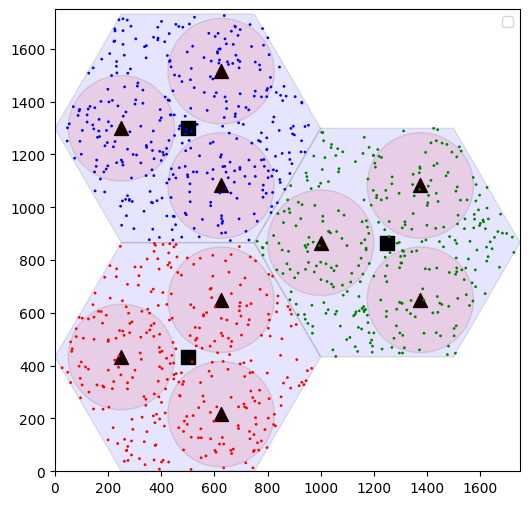

In [109]:
plt.figure(figsize=(6, 6))

ax = plt.gca()
for mBS in mBS_cells:
    mBS.plot(ax)
for sBS in sBS_cells:
    sBS.plot(ax)

colours = {mBS_cells[0]: 'red', mBS_cells[1]: 'green', mBS_cells[2]: 'blue'}
def bs_to_c(bs_list):
    return [colours[bs] for bs in bs_list]
plt.scatter(*zip(*ue_points), c=bs_to_c(ue_bs), marker='o', s=1)

plt.xlim(0, 1750)
plt.ylim(0, 1750)
plt.legend()
